In [1]:
import pandas as pd
df = pd.read_csv('西屯日報表train.csv',engine = 'python')
df.columns

Index(['month', 'day', 'hour', 'RH', 'StnPres', 'Temperature', 'AMB_TEMP',
       'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PH_RAIN', 'RAINFALL',
       'RAIN_COND', 'PM10', 'RH.1', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR', 'PM2.5'],
      dtype='object')

In [2]:
from matplotlib import pyplot
values = df.values
# specify columns to plot
groups = [3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<Figure size 640x480 with 5 Axes>

In [3]:
from sklearn import preprocessing 
import pandas as pd
import numpy as np
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s_tsub%d' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s_t' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s_tadd%d' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

In [4]:
'''
c = ['RH', 'StnPres', 'Temperature', 'CO', 'NO', 'NO2', 'NOx',
     'O3', 'RAINFALL', 'PM10', 'SO2', 'WD_HR',
     'WS_HR','PM2.5']#'WIND_DIREC'
'''
c = ['RH', 'StnPres', 'Temperature', 'CO', 'NO', 'NO2', 'NOx',
     'O3', 'PM10', 'SO2', 'WD_HR',
     'WS_HR','PM2.5', 'RAINFALL']#'WIND_DIREC'
dataset = df[c]
values = dataset.values
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform

In [5]:
scaler.fit(values[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]])
scaled = scaler.transform(values[:,[0,1,2,3,4,5,6,7,8,9,10,11,12]])#20
scaled

array([[0.74117647, 0.82657343, 0.20858896, ..., 0.09722222, 0.06153846,
        0.17112299],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.95833333, 0.03076923,
        0.21925134],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.09444444, 0.03076923,
        0.22994652],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.04166667, 0.22307692,
        0.07486631],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.03333333, 0.18461538,
        0.04812834],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.03888889, 0.16923077,
        0.02673797]])

In [6]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [12]:
scaler = joblib.load("scaler.save") #開
#scaler.transform(...)#20個feature

In [6]:
print(dataset.columns)
#scaled = np.array(values[:,0],scaled.data)
label_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
label_scaler.fit(values[:,13].reshape(-1, 1))
scaled_con = np.c_[scaled,label_scaler.transform(values[:,13].reshape(-1, 1))]#21
scaled_con

Index(['RH', 'StnPres', 'Temperature', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'SO2', 'WD_HR', 'WS_HR', 'PM2.5', 'RAINFALL'],
      dtype='object')


array([[0.74117647, 0.82657343, 0.20858896, ..., 0.06153846, 0.17112299,
        0.        ],
       [0.74117647, 0.82377622, 0.21472393, ..., 0.03076923, 0.21925134,
        0.        ],
       [0.71764706, 0.81958042, 0.23619632, ..., 0.03076923, 0.22994652,
        0.        ],
       ...,
       [0.78823529, 0.88531469, 0.38957055, ..., 0.22307692, 0.07486631,
        0.        ],
       [0.77647059, 0.88391608, 0.38957055, ..., 0.18461538, 0.04812834,
        0.        ],
       [0.77647059, 0.88671329, 0.38650307, ..., 0.16923077, 0.02673797,
        0.        ]])

In [9]:
joblib.dump(label_scaler, 'label_scaler.save') 

['label_scaler.save']

In [7]:
# frame as supervised learning
reframed = series_to_supervised(scaled_con,c, 12, 1)
def select(attr):
    c = []
    for i in range(4,13):
        c.append(attr + '_tsub' + str(i))
    return c

In [8]:
cf = []
for i in range(len(c)):
    cf.extend(select(c[i]))
#cf.append('PM2.5_t')
cf.append('RAINFALL_t')
reframed_df = reframed[cf]

In [9]:
from sklearn.model_selection import train_test_split  
import sklearn
values = reframed_df.values
X,y = values[:, :-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=12) 
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42057, 1, 126) (42057,) (10515, 1, 126) (10515,)


In [10]:
reframed_df.columns

Index(['RH_tsub4', 'RH_tsub5', 'RH_tsub6', 'RH_tsub7', 'RH_tsub8', 'RH_tsub9',
       'RH_tsub10', 'RH_tsub11', 'RH_tsub12', 'StnPres_tsub4',
       ...
       'RAINFALL_tsub4', 'RAINFALL_tsub5', 'RAINFALL_tsub6', 'RAINFALL_tsub7',
       'RAINFALL_tsub8', 'RAINFALL_tsub9', 'RAINFALL_tsub10',
       'RAINFALL_tsub11', 'RAINFALL_tsub12', 'RAINFALL_t'],
      dtype='object', length=127)

In [11]:
from sklearn.metrics import mean_squared_error
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


i = reframed_df.index % 24
want = [8,9,12,13,17,18,19]
reframed_dft = reframed_df[i == 7]
for x in want:
    reframed_dft = reframed_dft.append(reframed_df[i == x])
reframed_dft.sort_index()

from sklearn.model_selection import train_test_split  
import sklearn
values = reframed_dft.values
X,y = values[:, :-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=12) 

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [12]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [24]:
# cnnlstm
def baseline_model():
    # design network
    model = Sequential()
    #CNN
    model.add(Conv1D(filters=128, kernel_size=1, input_shape=(train_X.shape[1], train_X.shape[2],)))#kernel1 shape
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Conv1D(filters=128, kernel_size=1))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    #lstm
    model.add(LSTM(units=128, dropout=0.2,activation = 'sigmoid'))
    model.add(Dense(units = 100,activation = 'relu'))#sigmoid
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation = 'relu'))#
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [11]:
#gru
def baseline_model():
    inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm = LSTM(128, return_sequences=True, dropout=0.3)(inputs, training=True)
    lstm = GRU(32, return_sequences=False, dropout=0.3)(lstm, training=True)
    dense = Dense(50,activation = 'sigmoid')(lstm)
    out = Dense(1,activation = 'sigmoid')(dense)
    model = Model(inputs, out)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

MLP

In [12]:
def baseline_model():
    model=Sequential()
    model.add(Dense(units=256,
                    batch_input_shape=(None,  train_X.shape[1], train_X.shape[2]),
                    activation='sigmoid'))                  #使用 ReLu 激活函數
    model.add(Dropout(0.2))
    model.add(Dense(units=50))                       #建立隱藏層至輸出層連接                               
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  
    model.add(Flatten())
    model.add(Activation('sigmoid'))
    # optimizer
    adam = Adam(0.001)
    model.compile(optimizer=adam,
                  loss= 'mse',
                  metrics=['accuracy'])
    return model

bi-lstm

In [24]:
def baseline_model():
    model = Sequential()
    input_shape = (train_X.shape[1], train_X.shape[2])
    model.add(Bidirectional(LSTM(units=50, activation='sigmoid'),input_shape=input_shape))#,return_sequences=True
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    #model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

auto

In [174]:
def baseline_model():
    model = Sequential()
    model.add(LSTM(128, activation="sigmoid", input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(RepeatVector(1))
    model.add(LSTM(128, activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="sigmoid"))
    model.add(Dense(1))          
    model.compile(loss='mse', optimizer='adam')#root_mean_squared_error
    return model

In [164]:
def baseline_model():
    ### DEFINE LSTM AUTOENCODER ###
    inputs_ae = Input(shape=(train_X.shape[1], train_X.shape[2]))
    encoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=False, dropout=0.3)(encoded_ae, training=True)
    out_ae = Dense(1,activation = "sigmoid")(decoded_ae)
    model = Model(inputs_ae, out_ae)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

lstm

In [12]:
def baseline_model():
    inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm = LSTM(128, return_sequences=False, dropout=0.2,activation = 'sigmoid')(inputs, training=True)
#    lstm = LSTM(32, return_sequences=False, dropout=0.3)(lstm, training=True)
    dense = Dense(100,activation = "sigmoid")(lstm)
    out = Dense(1,activation = "sigmoid")(dense)
    model = Model(inputs, out)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [25]:
model = baseline_model()

In [26]:
history = model.fit(train_X, train_y, epochs=100, batch_size=400, validation_data=(test_X, test_y), verbose=2, shuffle=True)

Train on 42057 samples, validate on 10515 samples
Epoch 1/100
 - 6s - loss: 1.3141e-04 - mean_squared_error: 1.3141e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 2/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 3/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 4/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 5/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 6/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 7/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 8/100
 - 2s - loss: 1.1779e-04 - m

Epoch 64/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 65/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 66/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 67/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 68/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 69/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 70/100
 - 2s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 7.6219e-05 - val_mean_squared_error: 7.6219e-05
Epoch 71/100
 - 1s - loss: 1.1779e-04 - mean_squared_error: 1.1779e-04 - val_loss: 

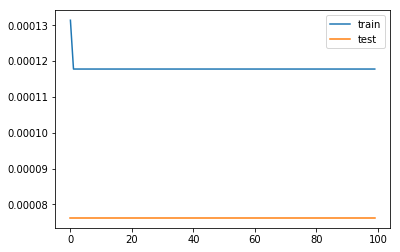

In [27]:
from matplotlib import pyplot
%matplotlib inline
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 126)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               130560    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 143,561
Trainable params: 143,561
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.save('CNNLSTM.h5') 
# 從 HDF5 檔案中載入模型
#from keras.models import load_model
#model = load_model('CNNLSTM.h5')
#https://blog.gtwang.org/programming/keras-save-and-load-model-tutorial/

In [17]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[0.00107598],
       [0.00138401],
       [0.00105446],
       ...,
       [0.00154452],
       [0.00142948],
       [0.00130525]], dtype=float32)

In [25]:
from keras import backend as K
from sklearn.metrics import mean_absolute_error
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop1(r):
    NN = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    NN_pred = NN([test_X,r])
    return np.vstack(NN_pred)
### COMPUTE STOCHASTIC DROPOUT ###
scores1 = []
for i in range(0,100):
    scores1.append(mean_absolute_error(stoc_drop1(0.5), test_y))
print(np.mean(scores1), np.std(scores1))

0.0374128355863981 0.00012898887302572367


In [18]:
def to_class(pre_pm):
    if pre_pm <= 11:
        return 0
    elif 11 < pre_pm <= 23:
        return  1
    elif 23 < pre_pm <= 35:
        return  2
    elif 35 < pre_pm <= 41:
        return  3
    elif 41 < pre_pm <= 47:
        return  4
    elif 47 < pre_pm <= 53:
        return  5
    elif 53 < pre_pm <= 58:
        return  6
    elif 58 < pre_pm <= 64:
        return  7
    elif 64 < pre_pm <= 70:
        return  8
    elif 70 < pre_pm:
        return  9
count = 0
ally = 0
for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(after_pm) >= 6 and to_class(pre_pm) >= 6:
        ally = ally + 1
        if to_class(after_pm) == to_class(pre_pm) :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
            count = count + 1
print(count/ally)#len(yhat))

ZeroDivisionError: division by zero

In [19]:
count = 0
ally = 0
for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(pre_pm) >= 6:
        ally = ally + 1
        if to_class(after_pm) >= 6 :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
            count = count + 1
print(count/ally)

0.0


In [28]:
inv_yhat = label_scaler.inverse_transform(yhat)
inv_y = label_scaler.inverse_transform(test_y.reshape(-1, 1))
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
# calculate average error percentage
avg = np.average(inv_y)
error_percentage = rmse / avg
print(error_percentage)

5.619903960008083
7.218761889341893


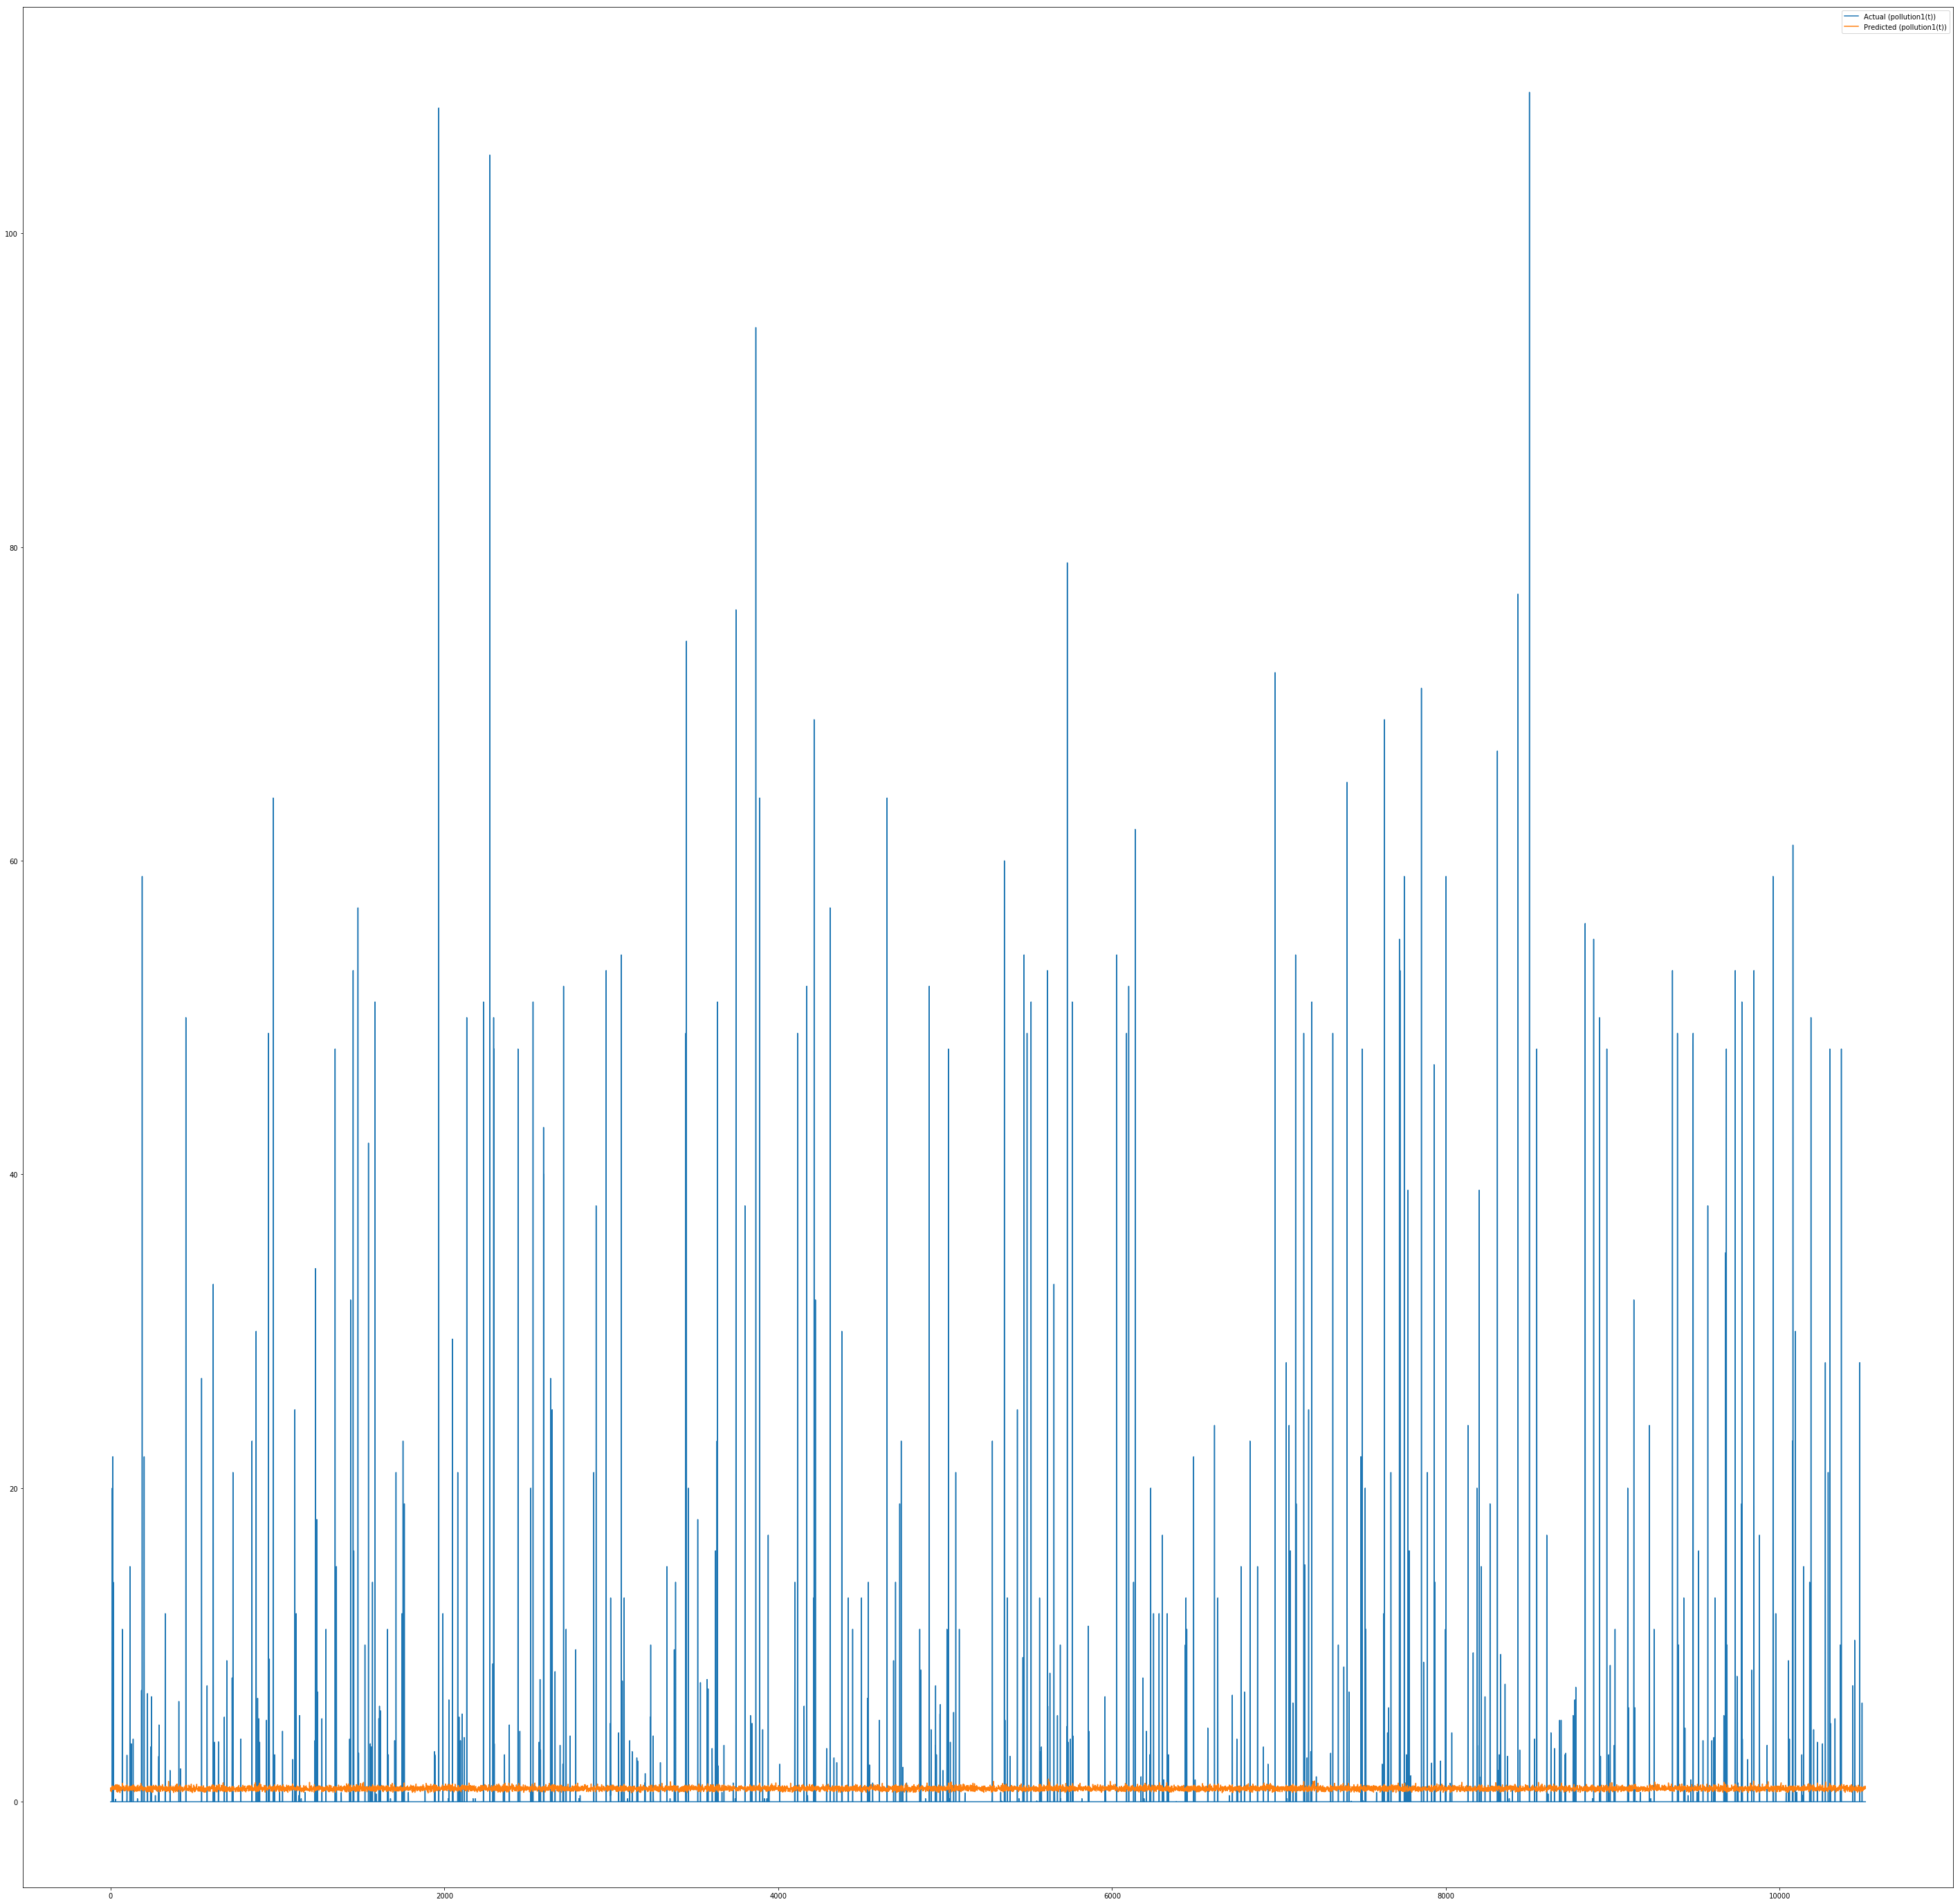

In [23]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(inv_y, label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(inv_yhat, label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()

In [29]:
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error,r2_score,mean_squared_error
print("The Explained Variance: %.2f" % explained_variance_score(inv_y, inv_yhat))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(inv_y,inv_yhat))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(inv_y, inv_yhat))
print("The r2_score: %.2f" % r2_score(inv_y, inv_yhat)) 
print("The mse: %.2f" % mean_squared_error(inv_y, inv_yhat))

The Explained Variance: 0.00
The Mean Absolute Error: 1.55 degrees Celcius
The Median Absolute Error: 0.85 degrees Celcius
The r2_score: 0.00
The mse: 31.58
